## Weather Data on NFL games for seasons 2009-2013
#### Matthew Johnson, August 9, 2018 (Last updated: August 13, 2018)

1. NFL data
2. Vegas odds
3. **Weather data**
<br><br>

Weather data is from http://nflsavant.com/about.php and originally contained weather for games between 1960-2013.

In [365]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

weather = pd.read_csv('/Users/mattjohnson/Desktop/Python2018/NFL/weather_20131231.csv')

We have weather for 1,119 games between 2009-2013:

In [421]:
weather[ weather['Season']>= 2009].shape

(1119, 12)

In [366]:
abbrev_dict = {"Arizona Cardinals": "ARI", "San Diego Chargers": "SD", "Minnesota Vikings": "MIN",
 "Miami Dolphins": "MIA", "Tennessee Titans": "TEN", "Carolina Panthers": "CAR",
 "New York Giants": "NYG", "Pittsburgh Steelers": "PIT", "Houston Texans": "HOU",
 "Seattle Seahawks": "SEA", "Cleveland Browns": "CLE", "Atlanta Falcons": "ATL",
 "Baltimore Ravens": "BAL", "Green Bay Packers": "GB", "Indianapolis Colts": "IND",
 "New Orleans Saints": "NO", "Cincinnati Bengals": "CIN", "Tampa Bay Buccaneers": "TB",
 "Oakland Raiders": "OAK", "New England Patriots": "NE", "Dallas Cowboys": "DAL",
 "Chicago Bears": "CHI", "Kansas City Chiefs": "KC", "Washington Redskins": "WAS",
 "San Francisco 49ers": "SF", "Buffalo Bills": "BUF", "New York Jets": "NYJ",
 "Philadelphia Eagles": "PHI", "Denver Broncos": "DEN", "Jacksonville Jaguars": "JAX",
 "Detroit Lions": "DET", "St. Louis Rams": "STL"}

In [477]:
home_columns = ['home_team', 'away_team','home_score', 'away_score', 'temperature',
       'wind_chill', 'humidity', 'wind_mph', 'date', 'Season', 'home_team']
away_columns = ['away_team', 'home_team', 'away_score', 'home_score', 'temperature',
       'wind_chill', 'humidity', 'wind_mph', 'date', 'Season', 'home_team']
all_columns = ['offenseTeam', 'defenseTeam','off_score', 'def_score', 'temperature',
       'wind_chill', 'humidity', 'wind_mph', 'date', 'Season', 'home_team']
    
def clean_weather_data(df):
    df['Season'] = pd.to_numeric(df['date'].str[-4:])
    df = df[ df['Season'] >= 2009]
    df['date'] = df['date'].str[:-5]
    df['wind_chill'] = df['wind_chill'].fillna(df['temperature'])
    df['humidity'] = pd.to_numeric(df['humidity'].str[:-1])
    df['humidity'] = df['humidity'].fillna(df['humidity'].mean())
    df['humidity'] = df['humidity'].round(0)
    df['wind_mph'] = pd.to_numeric(df['wind_mph']).fillna(0.0)
    df.drop(['id','weather'], axis=1, inplace=True)
    df['home_team'] = df['home_team'].map(abbrev_dict)
    df['away_team'] = df['away_team'].map(abbrev_dict)
    df.reset_index(drop=True, inplace=True)
    
    homedf, awaydf = df[home_columns], df[away_columns]
    df_list = [homedf, awaydf]
    for df in df_list:
        df.columns = all_columns 
        
    all_data = pd.concat([homedf.reset_index(drop=True), awaydf.reset_index(drop=True)])
            
    df = add_features(all_data)

    return df

def add_features(all_data):

    tempdf = all_data['date'].str.split('/').apply(pd.Series)
    
    for col in tempdf.columns:
        tempdf[col] =  tempdf[col].astype(str).apply(lambda x: x.zfill(2))
    
    all_data['date'] = tempdf[0] + '/' + tempdf[1]
    
    all_data['Year'] = np.where(tempdf[0].astype('int64') < 4, all_data['Season']+1, all_data['Season'])

    all_data['Season'] = all_data['Season'].astype(str)
    all_data['Year'] = all_data['Year'].astype(str)

    all_data['Date'] = all_data['date'] + '/'+ all_data['Year']

    all_data['mergeCode'] = all_data['Season'] + '-' + all_data['date'] + '-' + all_data['offenseTeam']
    
    all_data = sort_by_week(all_data)
    
    all_data['mergeCode2'] = all_data['Season']+'-'+ all_data['Week'].astype(str)+'-' + all_data['offenseTeam']
    
    return all_data

def create_mask(df, start_date, end_date):
    if end_date == 0:
        end_date = start_date + pd.to_timedelta(7,unit='d')
    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    return df.loc[mask]

def sort_by_week(data):
    
    week_list = []
    data['Week'] = 0

    for year in range(2009,2014):
        year_df = data[ data['Season']==str(year)]
        # sort by week
        year_df['Date'] = pd.to_datetime(year_df['Date'])
        mondays = list(year_df.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')['Date'].values)
        mondays.append(0)

        for i in range(0,min(17,len(mondays)-1)):
            
            current_week = create_mask(year_df, mondays[i], mondays[i+1])
            current_week['Week'] = (i+1) 
            week_list.append(current_week)
    week_data = pd.concat(week_list)
    
    return week_data

## Start Here

In [488]:
all_data = clean_weather_data(weather)

home: 1119 away: 1119
all: 2238
all_data mid add_feats: 2238
all_data after add_feats: 2058


In [644]:
# all_data.to_csv('weather_data09to13.csv')

There are 1428/2 = 714 games that are within the weeks 6 through 17:

In [653]:
weather_weeks6to17 = all_data[ (6 <= all_data['Week']) &  (all_data['Week']<= 17)]
weather_weeks6to17.shape

(1428, 16)

In [484]:
vegas_stats = pd.read_csv('/Users/mattjohnson/Desktop/Python2018/NFL/weeks6to16_vegas_and_stats.csv')
vegas_stats.shape

(2018, 58)

In [523]:
vegas_stats['mergeCode2'] = vegas_stats['Season_x'].astype(str) +'-'+ vegas_stats['Week_x'].astype('int64').astype(str)+'-' + vegas_stats['OffenseTeam']

In [617]:
merged_data = pd.merge(all_data.reset_index(drop=True), vegas_stats.reset_index(drop=True), 
                    on='mergeCode', how='inner')
merged_data2 = pd.merge(all_data.reset_index(drop=True), vegas_stats.reset_index(drop=True), 
                    on='mergeCode2', how='inner')


In [543]:
a = set(merged_data['gameid'].unique())
b = set(merged_data2['gameid'].unique())

sd = a.symmetric_difference(b)
intersect = a.intersection(b)

print('symmetric diff:', len(sd))
print('intersection:', len(intersect))

symmetric diff: 112
intersection: 455


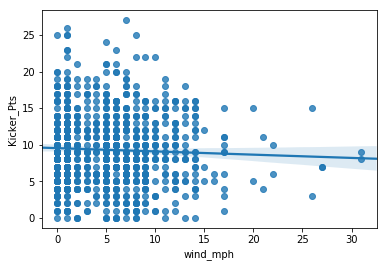

In [618]:
sns.regplot(x='wind_mph', y='Kicker_Pts', data=merged_data.dropna())

In [619]:
denver = merged_data[ merged_data['home_team'] == 'DEN']
notDenver = merged_data[ merged_data['home_team'] != 'DEN']


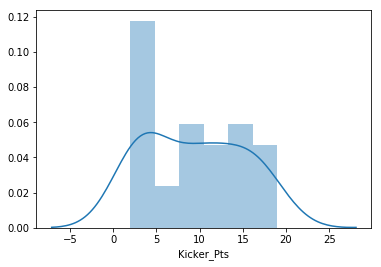

In [636]:
#denver['Kicker_Pts']
sns.distplot(denver['Kicker_Pts'], bins=6)

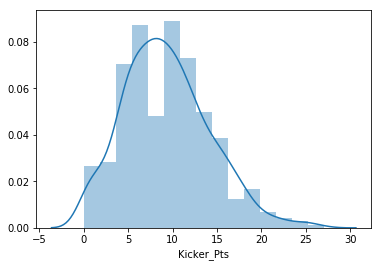

In [637]:
sns.distplot(notDenver['Kicker_Pts'], bins=15)

In [559]:
merged_data.isnull().sum().index

# seperate merged data with nans by where their nans lay and try to merge again on mergecode2
nan_data = merged_data[merged_data.isnull().any(axis=1)]
nan_data.isnull().sum()
nan_data1 = merged_data[merged_data['off_score'].isnull()]
nan_data2 = merged_data[merged_data['Season_x'].isnull()]

print(nan_data1.shape, ', ', nan_data2.shape)

(1084, 74) ,  (1125, 74)


In [564]:
drop_na_df = merged_data.dropna()
drop_na_df.shape

(934, 74)

In [568]:
#X = drop_na_df 'Date', 
drop_na_df = merged_data.dropna()
drops = ['Unnamed: 0', 'off_score', 'def_score', 'gameid', 'QB Kneel_rolling5', 'date_y', 
         'Season_x','mergeCode', 'offenseTeam_y', 'Week_y', 'Week_rolling5', 'date_x', 
         'gameid_rolling5', 'Season_y', 'defenseTeam_y', 'offenseTeam_x', 'defenseTeam_x',
        'DEF_QB Kneel_rolling5', 'DEF_gameid_rolling5', 'Week_x']
drop_na_df.drop(drops, axis=1, inplace=True)
#drop_na_df.columns

In [641]:
drop_na_df.shape

(934, 55)

In [569]:
drop_na_df['Kicker_Pts_rolling5b'] = drop_na_df['Kicker_Pts_rolling5'].copy()

In [571]:
from scipy.stats import norm, skew

numeric_feats = drop_na_df.drop('Date_x', axis=1).dtypes[drop_na_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = drop_na_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skew in numerical features: 



,Skew
TwoPointConv_rolling5,21.541
DEF_FG_50_rolling5,10.039
FG_50_rolling5,9.051
FieldGoalBad_rolling5,6.442
TwoPointConv,5.594
DEF_FG_40_rolling5,1.467
FG_40_rolling5,1.447
wind_mph,1.303
Kicker_Pts,0.479
Total,0.335


In [572]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
skewed_features = skewed_features.drop(['Kicker_Pts', 'Kicker_Pts_rolling5b'])

print("There are {} skewed numerical features to Box Cox transform".format(len(skewed_features)))

lam = 0.15
for feat in skewed_features:
    drop_na_df[feat] = boxcox1p(drop_na_df[feat], lam)
    

There are 44 skewed numerical features to Box Cox transform


In [313]:
# / len(merged_data)


In [273]:
# print( (merged_data.isnull().sum()).sort_values(ascending=False))

In [321]:
#drop_na_df.isnull().sum()
#drop_na_df = drop_na_df.dropna()

In [577]:
from sklearn.model_selection import train_test_split
X = drop_na_df.select_dtypes(include=['int64', 'float64']).fillna(0)
Xtrain, Xtest, ytrain, ytest = train_test_split(X.drop('Kicker_Pts', axis=1), X['Kicker_Pts'])

In [578]:
Xtrain.drop('Kicker_Pts_rolling5b', axis=1, inplace=True)
rolling_kicks = Xtest['Kicker_Pts_rolling5b'].copy()
Xtest.drop('Kicker_Pts_rolling5b', axis=1, inplace=True)

In [579]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 2018)
rf.fit(Xtrain, ytrain);

In [580]:
predictions = rf.predict(Xtest)
errors = abs(predictions - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 3.09


In [586]:
dataframe = pd.DataFrame({'actual': ytest, 'pred': predictions, 'rolling5': rolling_kicks})
dataframe['residual'] = dataframe['actual'] - dataframe['pred']
dataframe['residual2'] = dataframe['actual'] - dataframe['rolling5']

In [592]:
dataframe['abs_res'] = abs(dataframe['residual'])

In [597]:
dataframe['abs_res2'] = abs(dataframe['residual2'])

In [598]:
dataframe.sort_values(['abs_res']).describe()

,actual,pred,rolling5,residual,residual2,abs_res,abs_res2
count,234.000,234.000,234.000,234.000,234.000,234.000,234.000
mean,9.137,9.495,9.038,-0.358,0.098,3.090,3.363
std,4.653,2.702,2.197,3.909,4.264,2.412,2.614
min,0.000,2.876,2.000,-9.863,-11.000,0.003,0.000
25%,6.000,7.468,8.000,-2.848,-3.000,1.203,1.000
50%,9.000,9.152,9.000,-0.457,0.000,2.482,3.000
75%,12.000,11.549,10.000,2.275,3.000,4.318,5.000
max,25.000,15.992,15.000,11.031,14.000,11.031,14.000


In [639]:
def averagingModels(X, train, labels, models=[]):
    for model in models:
        model.fit(train, labels)
    predictions = np.column_stack([
        model.predict(X) for model in models
    ])
    return np.mean(predictions, axis=1)


In [ ]:
test_y = averagingModels(ytest, Xtrain, ytrain, [GBoost, lasso, ENet])

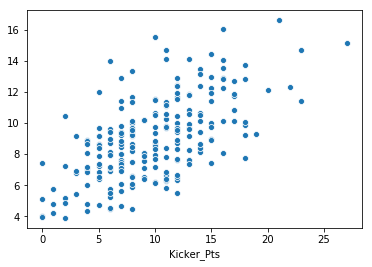

In [202]:
sns.scatterplot(x=ytest, y=predictions)

In [183]:
corrmat = pd.DataFrame(X.corr()['Kicker_Pts'])
corrmat.sort_values('Kicker_Pts', ascending=False)[1:12]

,Kicker_Pts
Kicker_Pts_rolling5,0.445654
DEF_Kicker_Pts_rolling5,0.445184
DEF_FieldGoalGood_rolling5,0.331577
FieldGoalGood_rolling5,0.289653
DEF_PointsScored_rolling5,0.242648
DEF_FG_40_rolling5,0.220711
PointsScored_rolling5,0.213869
FG_30_rolling5,0.196601
FG_40_rolling5,0.193731
DEF_FG_30_rolling5,0.171794


In [156]:
predictions = rf.predict(Xtest)
errors = abs(predictions - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 3.12


In [316]:
dataframe = pd.DataFrame({'actual': ytest, 'pred': predictions, 'rolling5': rolling_kicks})
dataframe['residual'] = dataframe['actual'] - dataframe['pred']
dataframe['residual2'] = dataframe['actual'] - dataframe['rolling5']

In [319]:
print( abs(dataframe['residual']).mean() )
print( abs(dataframe['residual2']).mean() )

3.2403504273504304
3.452991452991453


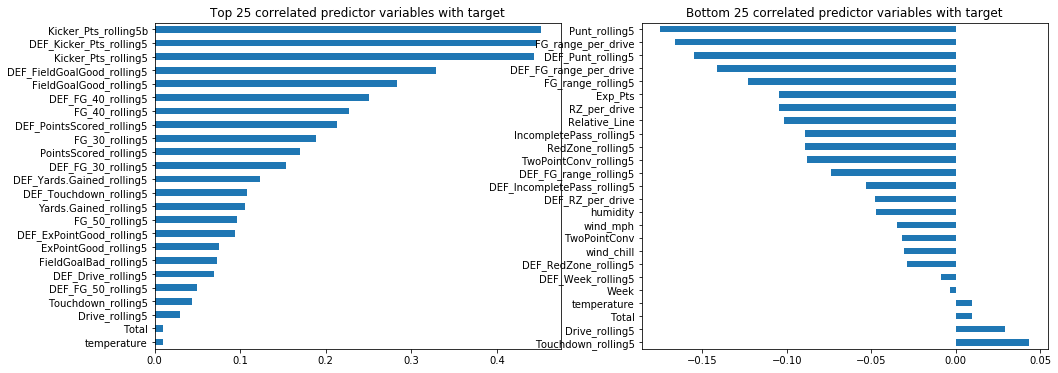

In [595]:
corr = X.corr()['Kicker_Pts']

corr_rank = corr.sort_values(ascending=False)

corr_rank_high = corr_rank[1:25]
corr_rank_low = corr_rank[-25:]

plt.subplots(figsize=(16,6))

plt.subplot(1, 2, 1)
highCorrs = corr_rank_high.sort_values(ascending=True)
highCorrs.plot(kind='barh')
plt.title('Top 25 correlated predictor variables with target')

plt.subplot(1, 2, 2)
inverseCorrs = corr_rank_low.sort_values(ascending=False)
inverseCorrs.plot(kind='barh')
plt.title('Bottom 25 correlated predictor variables with target');

In [343]:
len(X)
# 'Def_Kicker_Pts_rolling5', 'Kicker_Pts_rolling5', 'DEF_PointsScored_rolling5',
'PointsScored_rolling5', 'Yards.Gained_rolling5', 'DEF_Yards.Gained_rolling5', 
'DEF_Touchdown_rolling5', 'Touchdown_rolling5', 'DEF_FieldGoalGood_rolling5', 
'FieldGoalGood_rolling5', 'Total', 'Relative_Line', 'wind_mph', 'humidity', 'Exp_Pts'
'RZ_per_drive', 'DEF_RZ_per_drive', ''

484

In [294]:
test_list = []
pred_list = []
rank_list = []

for i in range(0,9):
    test_list.append(ytest[26*i:26*(1+i)])
    pred_list.append(predictions[26*i:26*(1+i)])
    
    test_rank = pd.DataFrame(test_list[i]).rank()
    pred_rank = pd.DataFrame(pred_list[i]).rank()

    ranks = pd.concat([test_rank.reset_index(drop=True), pred_rank.reset_index(drop=True)], axis=1)
    ranks.columns = ['test_rank', 'pred_rank']
    ranks['pred_rank']=ranks['pred_rank'].astype('int64')
    ranks['residual'] = ranks['test_rank']-ranks['pred_rank']
    rank_list.append(ranks)
    
rank_df = pd.concat(rank_list)

In [295]:
rank_resids = []

for _ in rank_list:
    abs_res = abs(_['residual']).mean()
    rank_resids.append(abs_res)
    

In [254]:
len(all_data['mergeCode'])
len(vegas_stats['mergeCode'])

2018

In [257]:
'''mergecodes = pd.DataFrame({'weather':all_data['mergeCode'], 
                           'vegas/fantasy':vegas_stats['mergeCode']})'''


weather = set(all_data['mergeCode'].values)
vegas = set(vegas_stats['mergeCode'].values)

print('weather:', len(weather), 'vegas:', len(vegas))

sd = weather.symmetric_difference(vegas)
intersect = weather.intersection(vegas)

print('symmetric diff:', len(sd))
print('intersection:', len(intersect))


weather: 2238 vegas: 2015
symmetric diff: 2387
intersection: 933


In [267]:
mergecodes = pd.DataFrame(list(sd))
mergecodes['team'] = mergecodes[0].str[-3:].str.lstrip('-')

In [338]:
all_data.head()

,offenseTeam,defenseTeam,off_score,def_score,temperature,wind_chill,humidity,wind_mph,date,Season,home_team,mergeCode
0,ARI,ATL,30,24,72,0.0,60.0,0.0,01/03,2009,ARI,2009-01/03-ARI
1,SD,IND,23,17,54,0.0,78.0,7.0,01/03,2009,SD,2009-01/03-SD
2,MIN,PHI,14,26,72,0.0,60.0,0.0,01/04,2009,MIN,2009-01/04-MIN
3,MIA,BAL,9,27,74,0.0,72.0,10.0,01/04,2009,MIA,2009-01/04-MIA
4,TEN,BAL,10,13,53,0.0,68.0,12.0,01/10,2009,TEN,2009-01/10-TEN


In [344]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [345]:
preds_LR = lin_reg.predict(Xtest)

In [346]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(ytest, preds_LR)
lin_rmse = np.sqrt(lin_mse)
print(lin_mse, ', ', lin_rmse)

15.071123244701317 ,  3.8821544591503976


In [350]:
abs(ytest-predictions).mean()
abs(ytest-preds_LR).mean()

3.159798893336429